In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu1"


import numpy as np
import cPickle as pickle
%matplotlib inline
from scipy.optimize import fmin_l_bfgs_b
import scipy.ndimage as nd
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer

from lasagne import layers, updates

from IPython.display import SVG

import theano
import theano.tensor as T

from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax


import PIL

from cStringIO import StringIO
import PIL.Image
from IPython.display import clear_output, Image, display

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess(mv, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - mv
def deprocess(mv, img):
    return np.dstack((img + mv)[::-1])

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: Tesla K20m (CNMeM is disabled)


##Load the model

### Choose which model to use

In [2]:
import vgg19, googlenet

model_name = "googlenet"

if model_name == "vgg":
    build_model = vgg19.build_model
    model_filename = "vgg19.pkl"
elif model_name == "googlenet":
    build_model = googlenet.build_model
    model_filename = "blvc_googlenet.pkl"

### Load it

In [3]:
net = build_model()
model_data = pickle.load(open(model_filename))
values = model_data['param values']
layers.set_all_param_values(net['prob'], values)

### Get some information from the model

In [4]:

model = net
classes = np.array(model_data["synset words"])

# mean value of the colors from which the model was trained on
# it is important because the model was trained on the images
# with subsracting the mean
if "mean value" in model_data:
    mean_value = (model_data["mean value"])
else:
    mean_value = np.array([104.0, 116.0, 122.0])

mean_value = mean_value[:, np.newaxis, np.newaxis]

### Visualize the model

In [5]:
draw_to_file(layers.get_all_layers(model['prob']), "{0}.svg".format(model_name))

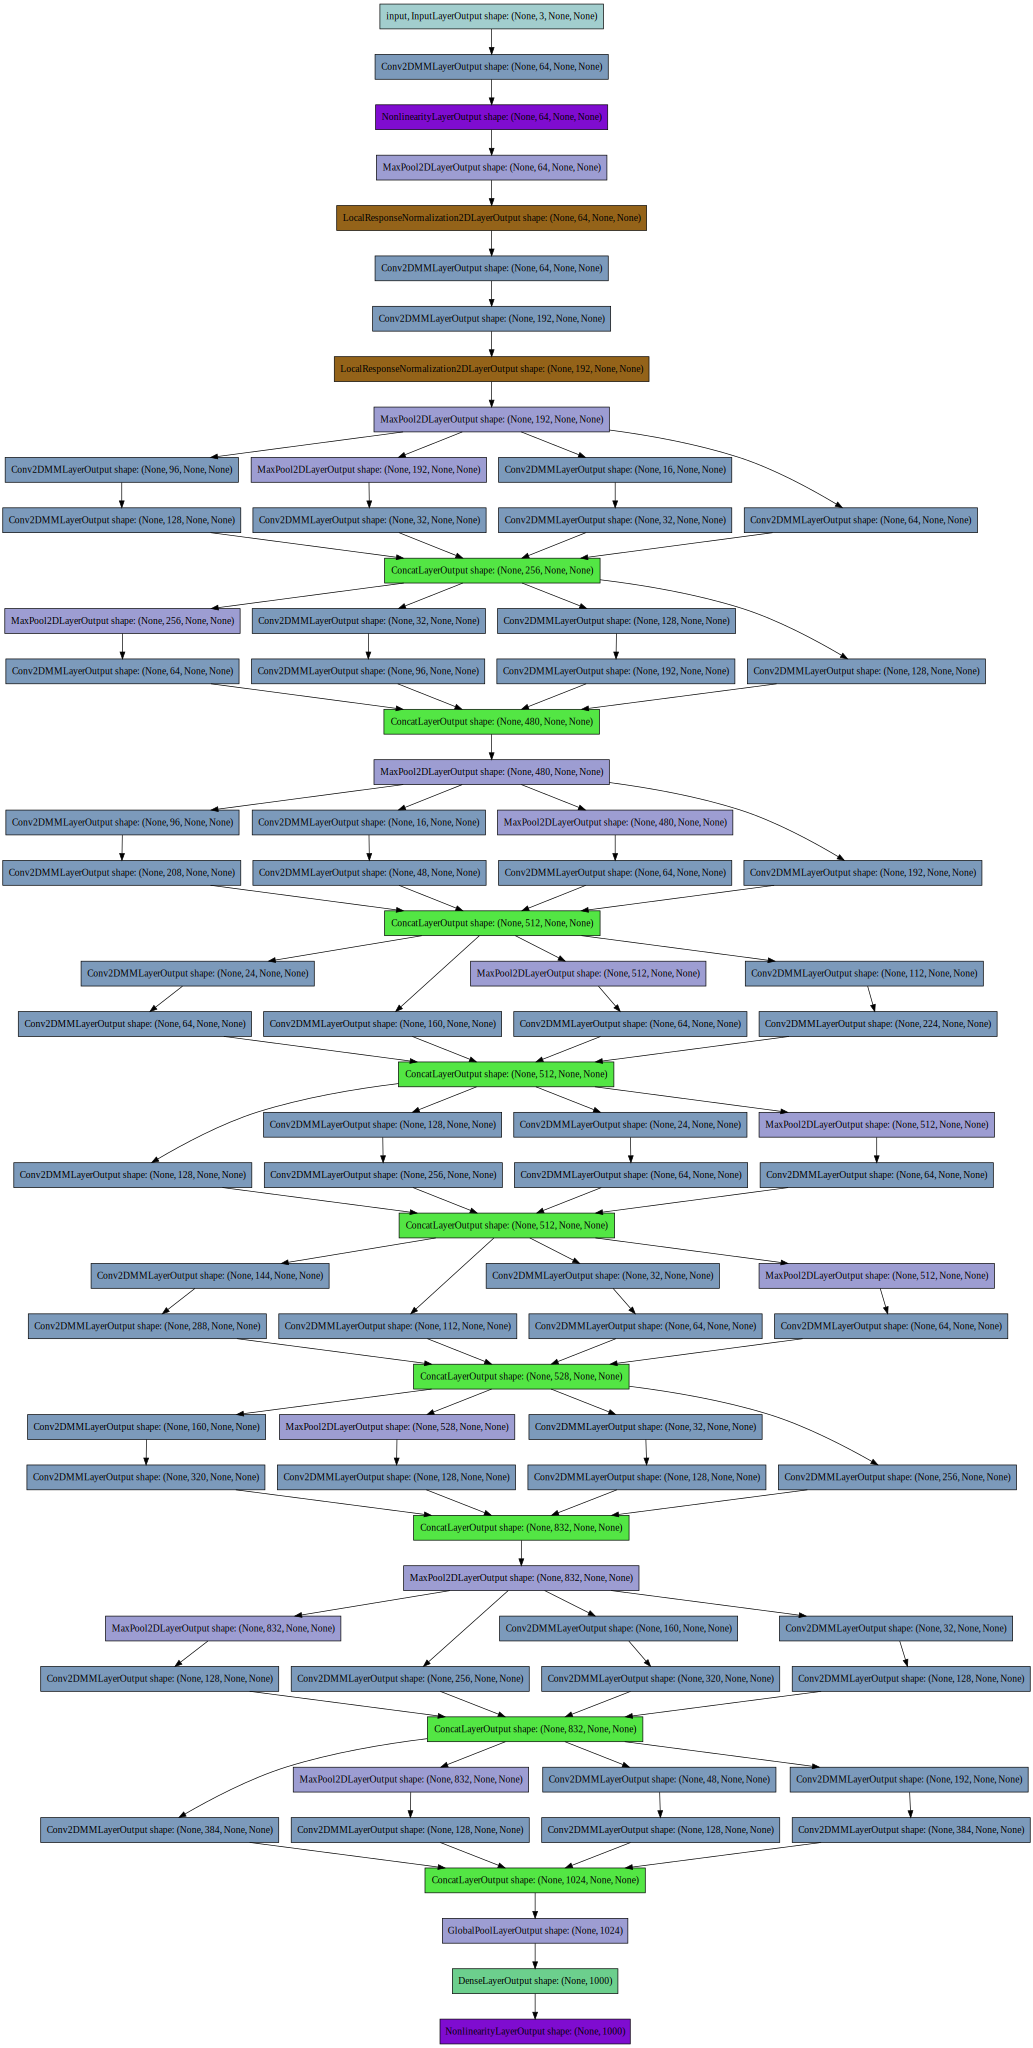

In [6]:
SVG("{0}.svg".format(model_name))

## Load the images

In [7]:
# replace the links by the images you want to use
!wget http://www.dph.am/sky1024px.jpg --output-document=sample.png
!wget http://i.ytimg.com/vi/s9dbAfjlrks/maxresdefault.jpg --output-document=sample2.png

--2015-09-17 22:14:01--  http://www.dph.am/sky1024px.jpg
Resolving www.dph.am... 198.244.107.6
Connecting to www.dph.am|198.244.107.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57024 (56K) [image/jpeg]
Saving to: “sample.png”

100%[======================================>] 57,024      42.0K/s   in 1.3s    

2015-09-17 22:14:03 (42.0 KB/s) - “sample.png” saved [57024/57024]

--2015-09-17 22:14:03--  http://i.ytimg.com/vi/s9dbAfjlrks/maxresdefault.jpg
Resolving i.ytimg.com... 216.58.208.206, 2a00:1450:4007:80d::200e
Connecting to i.ytimg.com|216.58.208.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142163 (139K) [image/jpeg]
Saving to: “sample2.png”

100%[======================================>] 142,163     --.-K/s   in 0.009s  

2015-09-17 22:14:03 (14.3 MB/s) - “sample2.png” saved [142163/142163]



### Show the loaded images

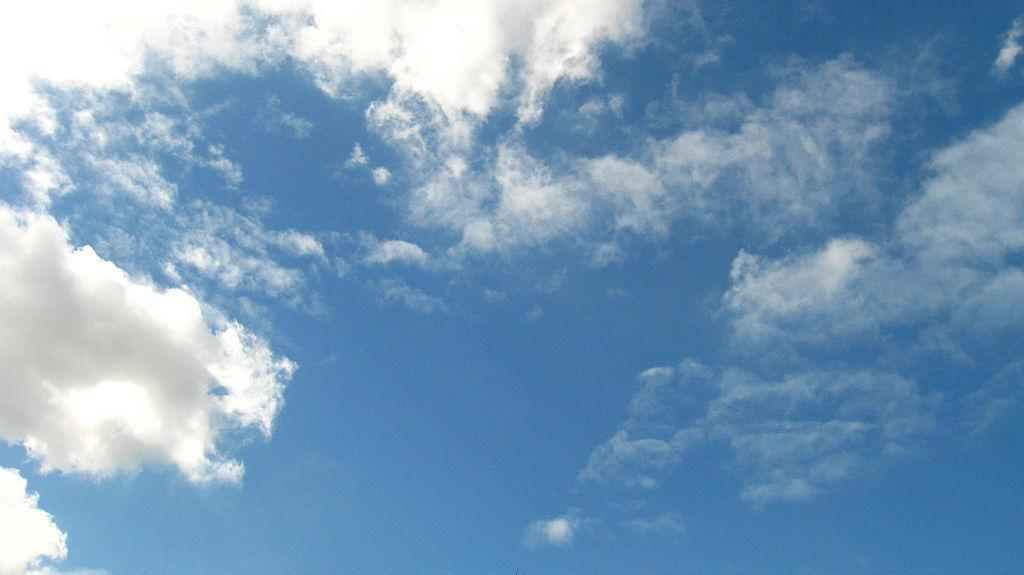

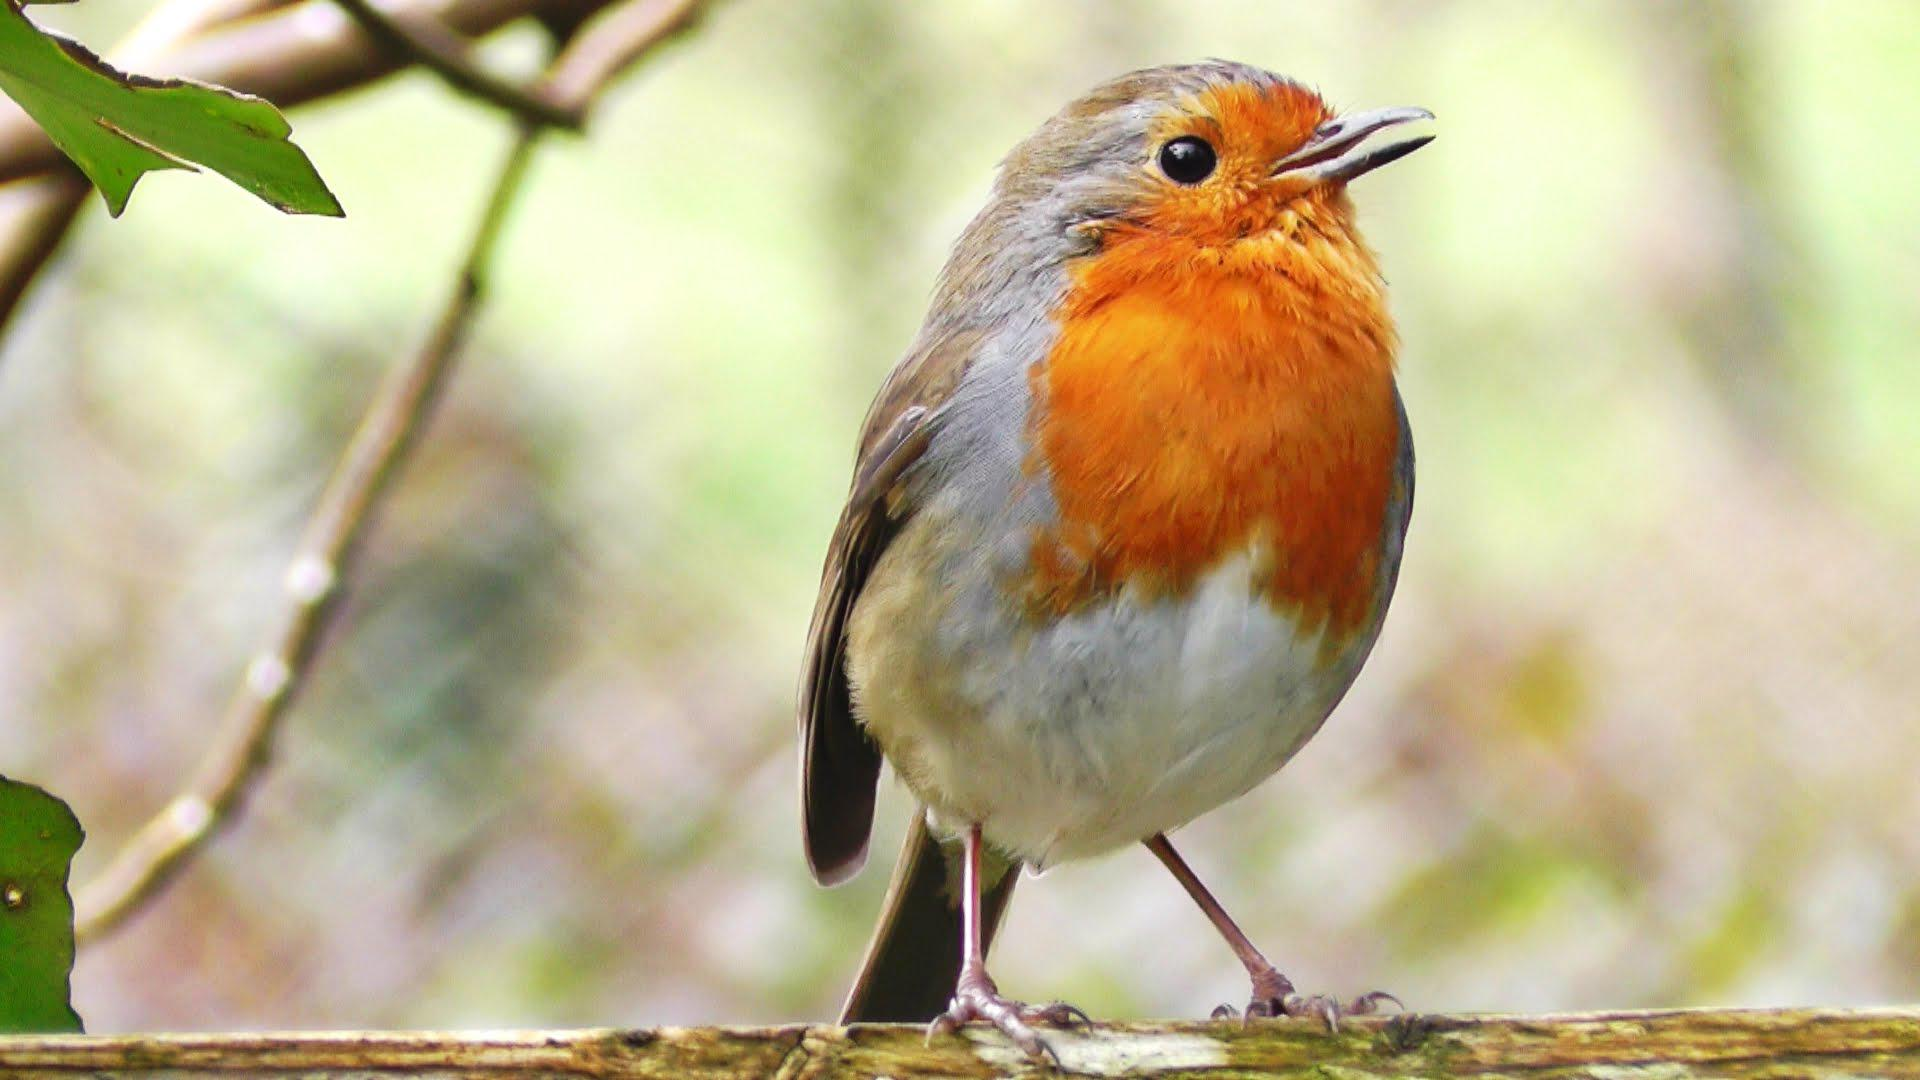

In [8]:
img_natural = np.float32(PIL.Image.open('sample.png'))
showarray(img_natural)
img_natural = np.float32(PIL.Image.open('sample2.png'))
showarray(img_natural)

##Blending Dream

In [131]:
# we are using these images
original_images = [
    np.float32(PIL.Image.open('sample2.png')),
    np.float32(PIL.Image.open('sample2.png')),
    #np.float32(PIL.Image.open('sample.png')),
]

In [132]:
# Show the name of the layers of the model, choose a set of layers
# and use them below
for name in model.keys():
    print(name)

input
conv1/7x7_s2
pool1/3x3_s2
pool1/norm1
conv2/3x3_reduce
conv2/3x3
conv2/norm2
pool2/3x3_s2
inception_3a/3x3_reduce
inception_3a/output
inception_3a/5x5_reduce
inception_3a/5x5
inception_3a/1x1
inception_3a/pool
inception_3a/pool_proj
inception_3a/3x3
inception_3b/3x3_reduce
inception_3b/pool
inception_3b/3x3
inception_3b/1x1
inception_3b/pool_proj
inception_3b/output
inception_3b/5x5_reduce
inception_3b/5x5
pool3/3x3_s2
inception_4a/3x3
inception_4a/3x3_reduce
inception_4a/pool
inception_4a/output
inception_4a/5x5
inception_4a/1x1
inception_4a/pool_proj
inception_4a/5x5_reduce
inception_4b/pool
inception_4b/1x1
inception_4b/5x5
inception_4b/pool_proj
inception_4b/5x5_reduce
inception_4b/output
inception_4b/3x3
inception_4b/3x3_reduce
inception_4c/1x1
inception_4c/5x5_reduce
inception_4c/pool_proj
inception_4c/3x3
inception_4c/pool
inception_4c/5x5
inception_4c/output
inception_4c/3x3_reduce
inception_4d/1x1
inception_4d/pool
inception_4d/3x3_reduce
inception_4d/pool_proj
inception

### Prepare the optimization procedure

In [143]:
# Choose the layers you want to use for blending
end_layers = [
    'inception_4b/3x3',
]

In [144]:
# Setup theano stuff
t_generated_image = T.tensor4()
t_input_images = T.tensor4()

input_activations = [] # the input (original images) activations of the chosen layers
generated_activations = [] # the generated activations of the chosen layers

for layer_name in end_layers:
    o_input_images = layers.get_output(model[layer_name], t_input_images)
    input_activations.append(o_input_images)
    
    o_generated_image = layers.get_output(model[layer_name], t_generated_image)[0]
    generated_activations.append(o_generated_image)

t_activations = []
for a in generated_activations:
    t_activations.append(a.type())

In [145]:
# Specify the kind of loss we want to minimize, 
# here squared error between desired  and generated
# activations is used
L = 0
for t_generated, t_desired in zip(generated_activations, t_activations):
    L += 0.5 * ((t_generated - t_desired) ** 2).sum()

In [146]:
# Generate theano functions to perform the optimization
get_activations = theano.function([t_input_images], input_activations)
get_gradients = theano.function([t_generated_image] + t_activations, 
                                 theano.grad(L, t_generated_image) )
get_loss = theano.function([t_generated_image] + t_activations, L)

### Prepare (initialize) the images

In [147]:
h, w = 200, 300 # we rescale to this size

In [148]:
# preprocess the original images
images = [preprocess(mean_value, image).astype(np.float32) for image in original_images]
images = [resize(image, (3, h, w), preserve_range=True).astype(np.float32) for image in images]
input_images = np.array(images)

In [152]:
# generate randomly the initial image and preprocess it
generated_image = np.random.uniform(0, 255, size=original_images[0].shape)
generated_image = preprocess(mean_value, generated_image).astype(np.float32)
#generated_image = images[0]
generated_image = resize(generated_image, (3, h, w), preserve_range=True).astype(np.float32)
generated_image = generated_image[np.newaxis, :, :, :]

In [153]:
#for lbfgs
def eval_loss(x0):
    x0 = (x0.reshape((1, 3, h, w))).astype(np.float32)
    return get_loss(x0, *layers_desired_activations).astype(np.float64)

def eval_grad(x0):
    x0 = (x0.reshape((1, 3, h, w))).astype(np.float32)
    g = get_gradients(generated_image_, *layers_desired_activations)
    return g.flatten().astype(np.float64)

## Optimize !

0.0


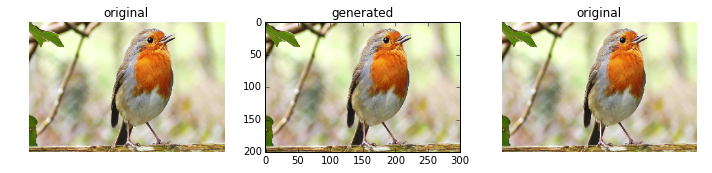

0.0


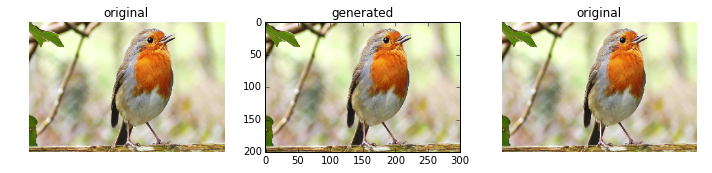

0.0


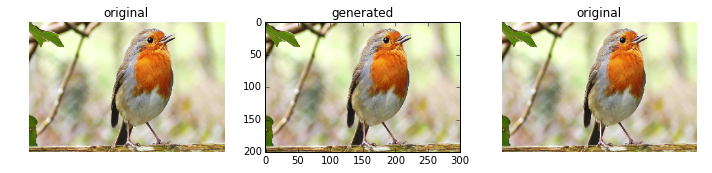

0.0


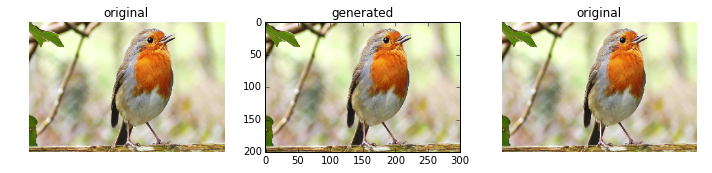

0.0


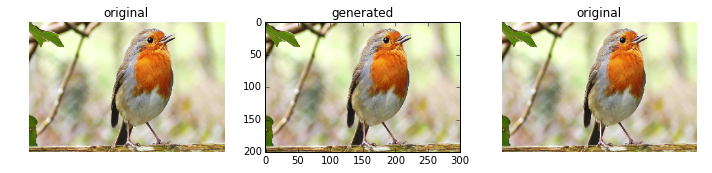

0.0


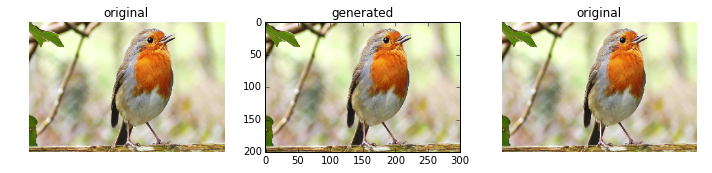

0.0


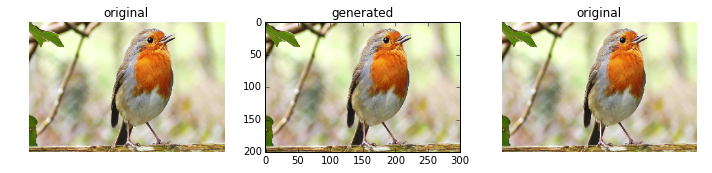

0.0


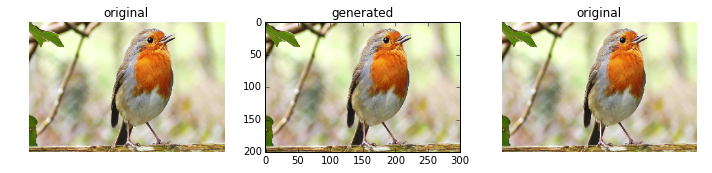

0.0


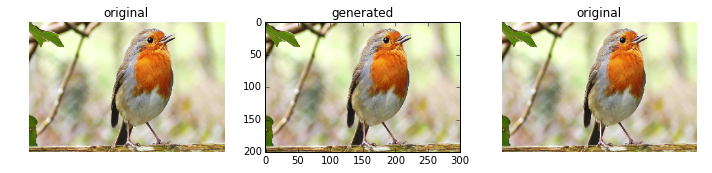

0.0


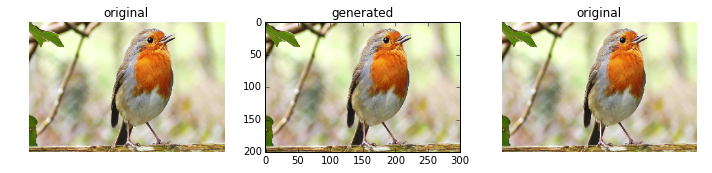

0.0


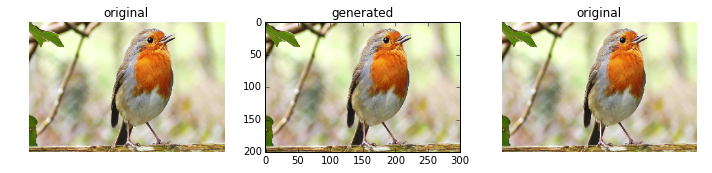

0.0


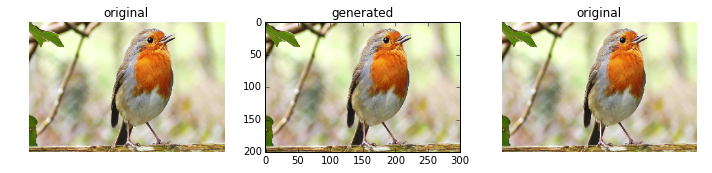

0.0


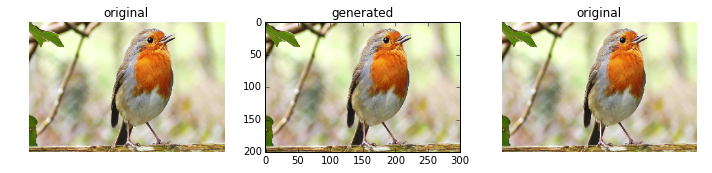

0.0


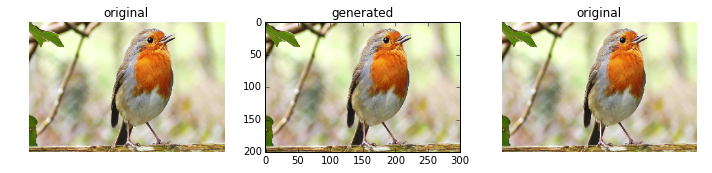

0.0


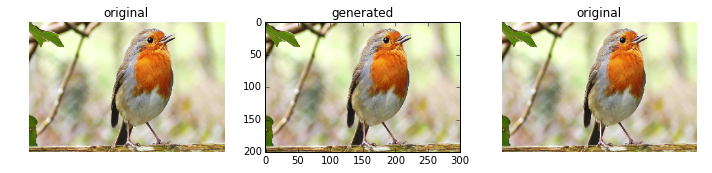

0.0


KeyboardInterrupt: 

In [154]:
alpha = 0.01 # learning rate of gradient descent
nb_iterations = 1000
generated_image_ = generated_image.copy()
loss_per_epoch = []
use_lbfgs = True # Use LBFGS to optimize better (if False, use gradient descent)

# get the activations of the original images for each layer
layers_activations = get_activations(input_images)
    
for i in range(nb_iterations):
    
    # Prepare the desired activations for the generated images
    # by combining the activations of the original images
    layers_desired_activations = []
    for layer_activations in layers_activations:
        # Blending operation
        
        # replace HERE by whatever blending operation you want
        # layer_activations is a 4D tensor in case the layer
        # is convolutional where : 
        # dim 1 = the image index
        # dim 2 = the index of the feature map
        # dim 3 = y
        # dim 4 = x
        # In case the layer is fully connected, layer_activations
        # is a matrix where:
        # dim 1 = the image index
        # dim 2 = the feature index
        # Here we just use the mean of the features of the original images
        layer_desired_activations = layer_activations.mean(axis=0)
        
        layers_desired_activations.append(layer_desired_activations)
    
    if use_lbfgs is True:
      
        x0, _, _ = fmin_l_bfgs_b(eval_loss, 
                                 generated_image_.flatten(), 
                                 fprime=eval_grad, maxfun=50)
        generated_image_[:] = (x0.reshape(generated_image_.shape).astype(np.float32))
    else:
        # just use gradient descent if use_lbfgs is False
        
        # get gradient w.r.t the input
        g = get_gradients(generated_image_, *layers_desired_activations)
        # do one step of gradient descent
        generated_image_ -= alpha * g

    l = get_loss(generated_image_, *layers_desired_activations)
    loss_per_epoch.append(l)
    if i % 1==0:
        print(l)
    if i % 1==0:
        fig = plt.figure(figsize=(10, 10))
        plt.subplot(1, 3, 1)
        out = deprocess(mean_value, images[0])
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("original")
        plt.axis('off')
        plt.imshow(out)
        plt.subplot(1, 3, 2)
        out = deprocess(mean_value, generated_image_[0])
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("generated")
        plt.imshow(out)
        plt.subplot(1, 3, 3)
        out = deprocess(mean_value, images[1])
        out = np.uint8(np.clip(out, 0, 255))
        plt.title("original")
        plt.axis('off')
        plt.imshow(out)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(loss_per_epoch)